In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW, Optimizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scratchers.attn import Attention, MultiheadAttention
from scratchers.transformer import TransformerBlock, TransformerDecoder, Config

# Data generation

In [2]:
SOURCE_SEQ_LEN = 6
TARGET_SEQ_LEN = 6

DATA_SIZE = 5000
TRAIN_SIZE = int(DATA_SIZE * 0.8)
TEST_SIZE = DATA_SIZE - TRAIN_SIZE

radii = np.random.ranf((DATA_SIZE)) * 9 + 1
starting_radian = np.random.ranf((DATA_SIZE)) * 2 * np.pi
directions = np.random.randint(2, size=DATA_SIZE) * 2 - 1

def to_cartesian(
    radius: float,
    start_radian: float, 
    direction: int
):
    delta = 2 * np.pi / (SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    seq = np.array([
        np.array([
            radius * np.cos(start_radian + (i * direction * delta)),
            radius * np.sin(start_radian + (i * direction * delta))
        ])
        for i in range(SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    ])
    source_seq = seq[:-1]
    target_seq = seq[1:]
    return source_seq, target_seq

def make_data():
    X = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN + TARGET_SEQ_LEN) - 1, 2))
    Y = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN + TARGET_SEQ_LEN) - 1, 2))
    for idx, (radius, start_radian, direction) in enumerate(zip(radii, starting_radian, directions)):
        x, y = to_cartesian(radius, start_radian, direction)
        X[idx, :, :] = x
        Y[idx, :, :] = y

    return (
        torch.from_numpy(X[:TRAIN_SIZE]).float(), 
        torch.from_numpy(Y[:TRAIN_SIZE]).float(),
        torch.from_numpy(X[TRAIN_SIZE:]).float(), 
        torch.from_numpy(Y[TRAIN_SIZE:]).float()
    )

X_train, y_train, X_test, y_test = make_data()

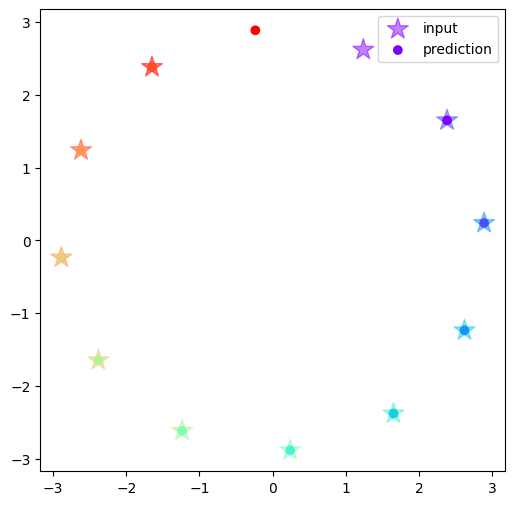

In [3]:
def plot_circle(input, prediction, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    colors = cm.rainbow(np.linspace(0, 1, len(input)))
    plt.scatter(
        input[:, 0], input[:, 1], label="input", marker="*", s=250, alpha=0.5, color=colors
    )
    plt.scatter(prediction[:, 0], prediction[:, 1], label="prediction", color=colors)
    plt.legend()

plot_circle(X_train[7], y_train[7])

# Train

In [4]:
cfg = Config(
    input_size=2,
    attn_d_k=32,
    transformer_proj_dim=32,
    dropout=0.2,
    nlayers=8,
    is_self_attn=False,
    max_seq_len=TARGET_SEQ_LEN + SOURCE_SEQ_LEN,
    nheads=2
)

def attn_factory(config: Config):
    return Attention(
        input_size=config.input_size,
        d_k=config.attn_d_k,
        # nheads=config.nheads,
        is_self_attn=config.is_self_attn,
        dropout=config.dropout
    )

In [5]:
class Trainer:

    def __init__(
        self,
        train_data_loader: DataLoader,
        test_data_loader: DataLoader,
        optimizer: Optimizer,
        model: nn.Module,
        epochs: int = 10,
    ):
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self.optimizer = optimizer
        self.model = model
        self.epochs = epochs

    def train(self, loss_fn: callable):
        for epoch in range(self.epochs):
            losses = []
            self.model.train()
            for x_batch, y_batch in self.train_data_loader:
                out = self.model(x_batch)
                loss = loss_fn(out, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                losses.append(loss.detach().cpu().numpy())

            print(f"Train loss at epoch ({epoch}): ", np.array(losses).mean())

            with torch.no_grad():
                self.model.eval()
                test_losses = []
                for x_batch, y_batch in self.test_data_loader:
                    out = self.model(x_batch)
                    loss = loss_fn(out, y_batch)
                    test_losses.append(loss.detach().cpu().numpy())

                print(f"Test loss at epoch ({epoch}): ", np.array(test_losses).mean())

In [6]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
decoder = TransformerDecoder(cfg, attn_factory)
trainer = Trainer(
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
    optimizer=AdamW(decoder.parameters()),
    model=decoder,
    epochs=15
)

def loss(predictions, target):
    return ((predictions - target) ** 2).mean()

trainer.train(loss_fn=nn.L1Loss())

Train loss at epoch (0):  1.7136964
Test loss at epoch (0):  1.3607211
Train loss at epoch (1):  1.5421578
Test loss at epoch (1):  1.4110504
Train loss at epoch (2):  1.5178081
Test loss at epoch (2):  1.3159149
Train loss at epoch (3):  1.5205047
Test loss at epoch (3):  1.3345891
Train loss at epoch (4):  1.4792
Test loss at epoch (4):  1.3136524
Train loss at epoch (5):  1.439384
Test loss at epoch (5):  1.2859514
Train loss at epoch (6):  1.4209208
Test loss at epoch (6):  1.296342
Train loss at epoch (7):  1.4072417
Test loss at epoch (7):  1.3006744
Train loss at epoch (8):  1.4051523
Test loss at epoch (8):  1.2812463
Train loss at epoch (9):  1.3758788
Test loss at epoch (9):  1.2814415
Train loss at epoch (10):  1.3863752
Test loss at epoch (10):  1.2799026
Train loss at epoch (11):  1.3825933
Test loss at epoch (11):  1.2826159
Train loss at epoch (12):  1.3659488
Test loss at epoch (12):  1.278377
Train loss at epoch (13):  1.376276
Test loss at epoch (13):  1.2795405
Train

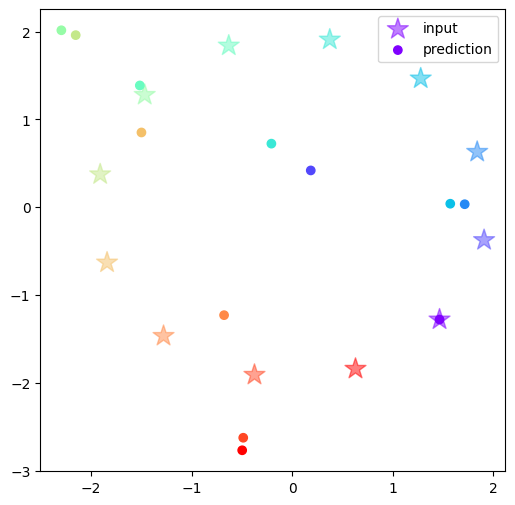

In [16]:
decoder.eval()
x_sample, y_sample = test_dataset[np.random.randint(0, TEST_SIZE)]
predictions = decoder.forward(x_sample.unsqueeze(0))[0]
labels = torch.cat((x_sample, y_sample[-1:]))

plot_circle(
    input=labels.detach().numpy()[0:],
    prediction=torch.cat((labels[0:1, :], predictions)).detach().numpy()[0:],
)